In [1]:
!pip3 install --upgrade pip
!pip3 install einops

In [2]:
# Import of libraries
import random
import imageio
import numpy as np
from argparse import ArgumentParser

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import einops
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST, FashionMNIST

%matplotlib widget

In [3]:
# Setting reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Definitions
STORE_PATH_MNIST = f"ddpm_model_mnist.pt"
STORE_PATH_FASHION = f"ddpm_model_fashion.pt"

In [4]:
no_train = False
fashion = False
batch_size = 4
n_epochs = 20
lr = 0.001

In [5]:
store_path = "ddpm_fashion.pt" if fashion else "ddpm_mnist.pt"

In [6]:
# Loading the data and convert the images into a tensor and normalize them to [-1, 1]
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)
])
ds_fn = FashionMNIST if fashion else MNIST
dataset = ds_fn(root="./datasets", train=True, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [7]:
def show_images(images, title=""):
    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()
    
    # Defining number of rows and columns
    fig = plt.figure(figsize=(6, 6))
    rows = int(len(images) ** (1/2))
    cols = round(len(images) / rows)

    # Populating figure with subplots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)
            
            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                plt.axis("off")
                idx += 1
        
    fig.suptitle(title)

    plt.show()

In [8]:
def show_first_batch(loader):
    for batch in loader:
        show_images(batch[0], "Images in the first batch")
        break

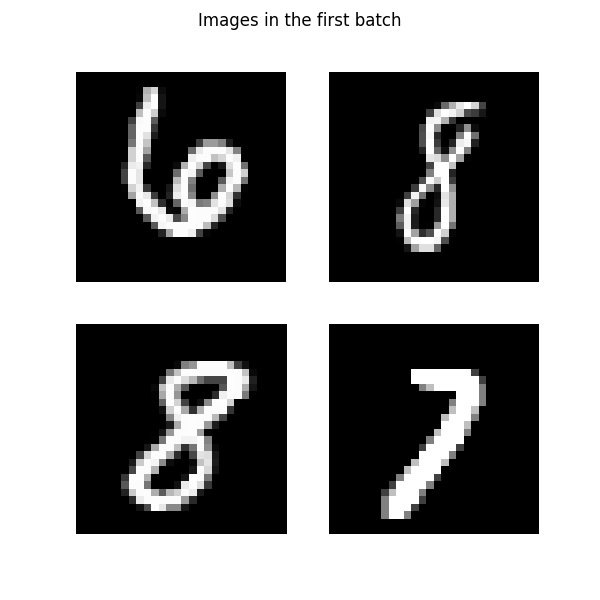

In [9]:
# Optionally, show a batch of regular images
show_first_batch(loader)

In [10]:
# Getting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

Using device: cpu	CPU


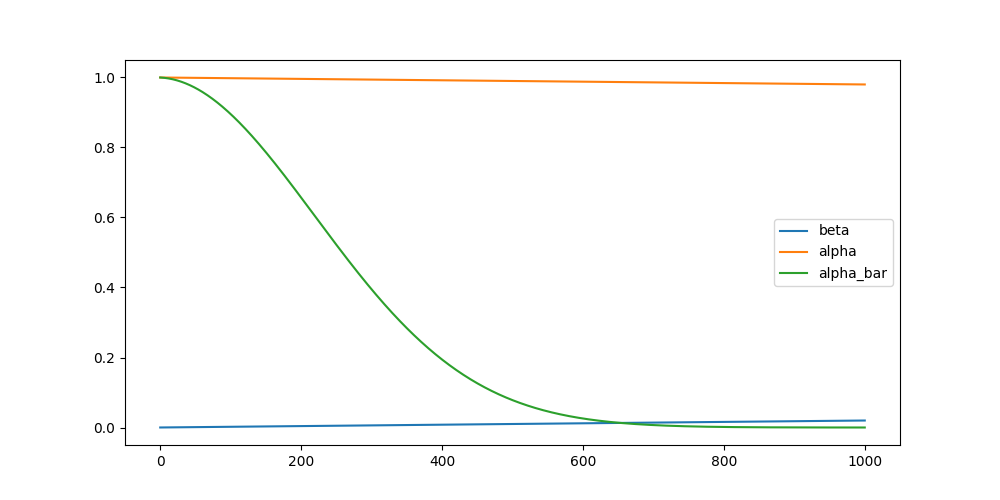

In [11]:
plt.figure(figsize=(10, 5))
betas = torch.linspace(10**-4, 0.02, 1000).to(device) 
alphas = 1 - betas
alpha_bars = torch.tensor([torch.prod(alphas[:i+1]) for i in range(len(alphas))]).to(device)
plt.plot(betas.cpu().numpy(), label="beta")
plt.plot(alphas.cpu().numpy(), label="alpha")
plt.plot(alpha_bars.cpu().numpy(), label="alpha_bar")
plt.legend()
plt.show()

In [44]:
class MyDDPM(nn.Module):
    def __init__(self, network, n_steps=200, min_beta=10**-4, max_beta=0.02, device=None, image_chw=(1,28,28)):
        super().__init__()
        # self.network = network.to(device)
        self.n_steps = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device)

        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x0, t, eta=None):
        # Make input image more noise (we can directly skip to the desired step)
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)
        
        noisy = a_bar.sqrt().reshape(n,1,1,1) * x0 + (1 - a_bar).sqrt().reshape(n,1,1,1) * eta
        return noisy
    
    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, t)

In [45]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.zeros(n, d)                                       # Shape: (n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])    # Shape: (d,)
    wk = wk.reshape((1, d))                                             # Shape: (1, d)
    t = torch.arange(n).reshape((n, 1))                                 # Shape: (n, 1)
    embedding[:, ::2] = torch.sin(t * wk[:, ::2])                       # Shape: (n, d)      
    embedding[:, 1::2] = torch.cos(t * wk[:, ::2])                      # Shape: (n, d)
    return embedding

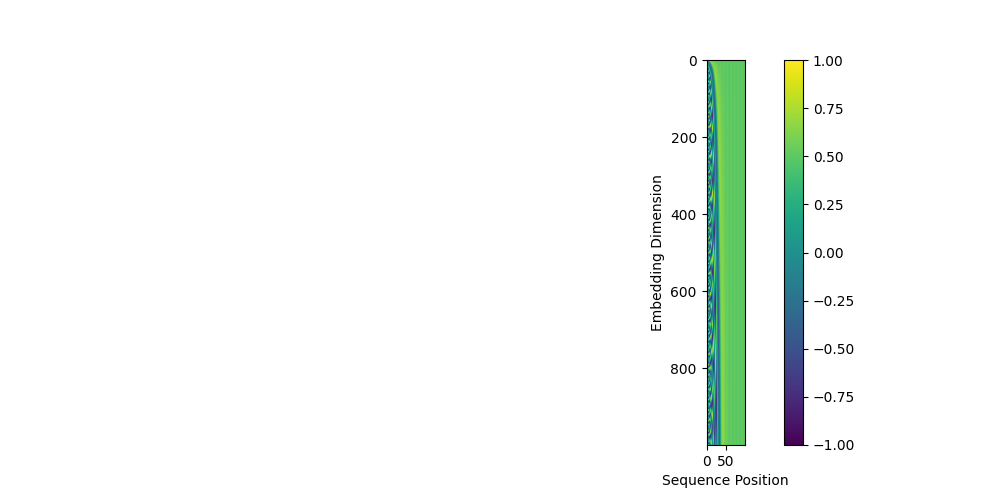

In [46]:
emb = sinusoidal_embedding(1000, 100)
# # Plot the embedding for each position
# fig, ax = plt.subplots()
# for i in range(100):
#     ax.plot(emb[:,i], label=f"Dimension {i+1}")
# ax.set_title("Positional Embedding")  
# ax.legend()

# plt.show()
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(emb)

# Show sequence positions and embedding dimensions  
# ax.set_xticks(np.arange(1000))
# ax.set_yticks(np.arange(100))

# Set labels
ax.set_xlabel('Sequence Position')
ax.set_ylabel('Embedding Dimension')

# Show color bar  
fig.colorbar(im)

In [47]:
class MyBlock(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(MyBlock, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out

In [48]:
class MyUNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(MyUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(num_embeddings=n_steps, embedding_dim=time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            MyBlock((1, 28, 28), 1, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            MyBlock((10, 14, 14), 10, 20),
            MyBlock((20, 14, 14), 20, 20),
            MyBlock((20, 14, 14), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            MyBlock((20, 7, 7), 20, 40),
            MyBlock((40, 7, 7), 40, 40),
            MyBlock((40, 7, 7), 40, 40)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyBlock((40, 3, 3), 40, 20),
            MyBlock((20, 3, 3), 20, 20),
            MyBlock((20, 3, 3), 20, 40)
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1)
        )

        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            MyBlock((80, 7, 7), 80, 40),
            MyBlock((40, 7, 7), 40, 20),
            MyBlock((20, 7, 7), 20, 20)
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            MyBlock((40, 14, 14), 40, 20),
            MyBlock((20, 14, 14), 20, 10),
            MyBlock((10, 14, 14), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            MyBlock((20, 28, 28), 20, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10, normalize=False)
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x, t):
        # x is (N, 2, 28, 28) (image with positinoal embedding stacked on channel dimension)
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1)) # N, 10, 28, 28
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1)) # N, 20, 14, 14
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1)) # N, 40, 7, 7

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1)) # N, 40, 3, 3

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1) # N, 80, 7, 7
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1)) # N, 20, 7, 7

        out5 = torch.cat((out2, self.up2(out4)), dim=1) # N, 40, 14, 14
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1)) # N, 10, 14, 14

        out = torch.cat((out1, self.up3(out5)), dim=1) # N, 20, 28, 28
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1)) # N, 1, 28, 28

        out = self.conv_out(out) # N, 1, 28, 28

        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )


In [49]:
def show_forward(ddpm, loader, device):
    # Showing the forward process
    noise_through_time = []
    for batch in loader:
        imgs = batch[0]

        noise_through_time.append(imgs[0])
    

        for percent in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
            noisy_images = ddpm(imgs.to(device), [int(percent*ddpm.n_steps) - 1 for _ in range(len(imgs))])
            show_images(noisy_images, f"Noisy images after {percent*100}% of steps")
            noise_through_time.append(noisy_images[0])

        break

    plt.subplots(1, 11, figsize=(10, 5))
    for i in range(len(noise_through_time)):
        plt.subplot(1, 11, i + 1)
        plt.imshow(noise_through_time[i][0].cpu().numpy(), cmap="gray")
        plt.axis("off")
    plt.show()

In [50]:
eta_thetas = []
partially_denosied_images = []

In [98]:
def generate_new_images(ddpm, n_samples=4, device=None, frames_per_gif=100, gif_name="sampling.gif", c=1, h=28, w=28):
    """Given a ddpm model, a number of sampples to be generated and a device, returns some newly generated samples"""

    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
    frames = []

    with torch.no_grad():
        if  device is None:
            device = ddpm.device
        
        # Starting from random noise
        x = torch.randn(n_samples, c, h, w).to(device)

        # plt.imshow(x[0].detach().cpu().numpy()[0], cmap="gray")
        # plt.show()

        # print(list(range(ddpm.n_steps))[::-1])

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]): # Going backwards
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long() 
            eta_theta  = ddpm.backward(x, time_tensor)
            eta_thetas.append(eta_theta)
            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoisign the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)
            partially_denosied_images.append(x)

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)

                # Option 1: sigma_t squared = beta_t
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                # Adding some more noise like in Langevin Dynamics fashion
                x = x + sigma_t * z
            
            # Adding frames to the GIF
            if idx in frame_idxs or t == 0:
                # Putting digits in range[0,255]
                normalized = x.clone()
                for i in range(len(normalized)):
                    normalized[i] -= torch.min(normalized[i])
                    normalized[i] *= 255 / torch.max(normalized[i])
                
                # Reshaping batch (n, c, h, w) to be a square frame
                frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_samples ** 0.5))
                frame = frame.cpu().numpy().astype(np.uint8)
                
                # Rendering frame
                frames.append(frame)

    # Storing the GIF
    with imageio.get_writer(gif_name, mode="I") as writer:
        for idx, frame in enumerate(frames):
            if frame.shape[-1] == 1: frame = np.concatenate([frame] * 3, axis=-1)
            writer.append_data(frame)
            
            if idx == len(frames) - 1:
                for  _ in range(frames_per_gif // 3):
                    if frame.shape[-1] == 1: frame = np.concatenate([frame] * 3, axis=-1)
                    writer.append_data(frame)
    return x


In [99]:
# Defining model
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
ddpm = MyDDPM(MyUNet(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)

In [103]:
sum([p.numel() for p in ddpm.parameters()])

606852

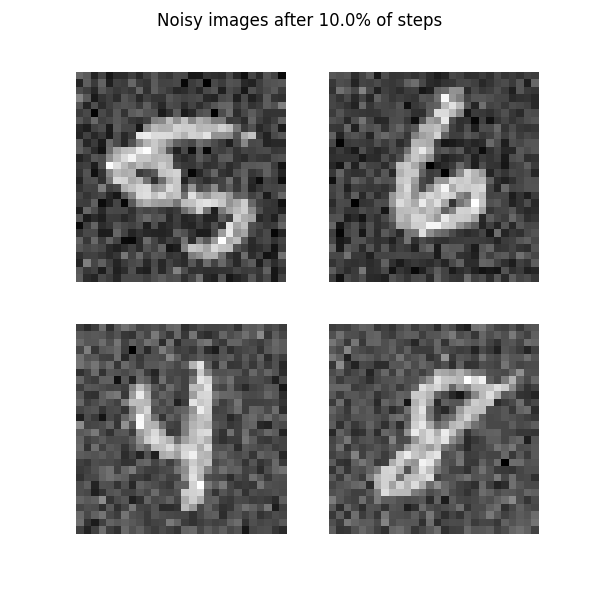

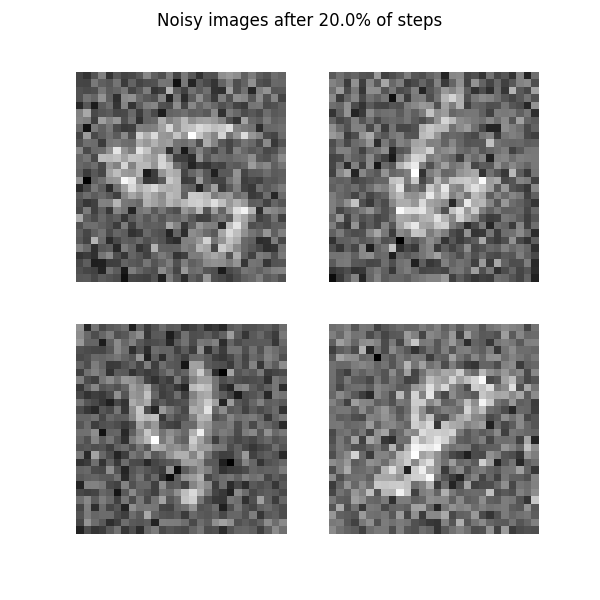

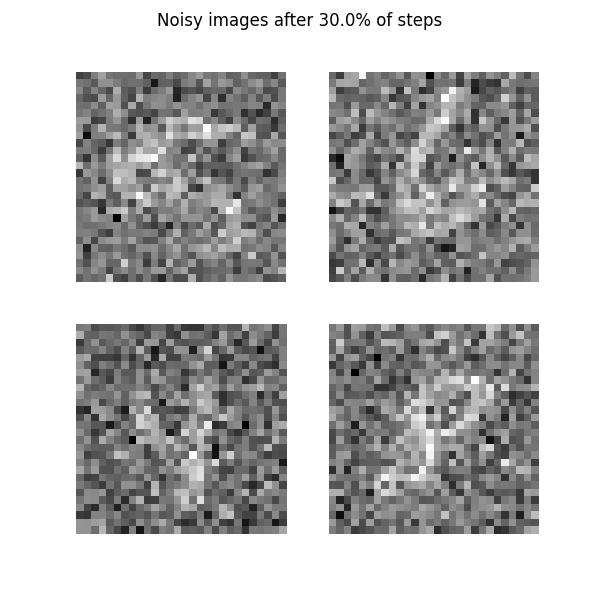

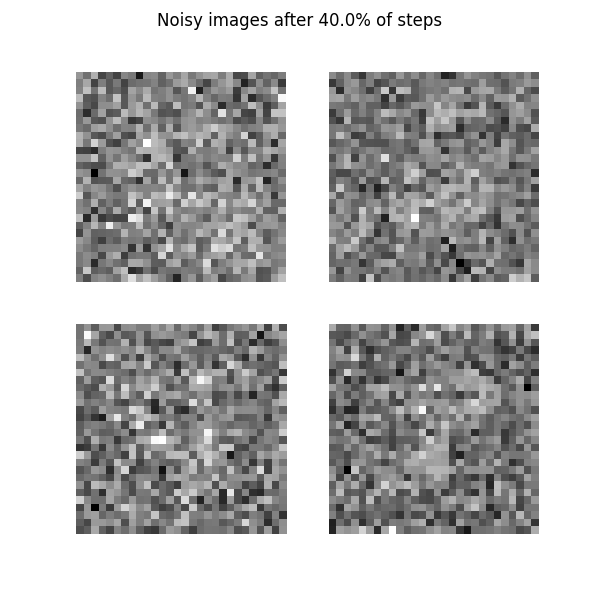

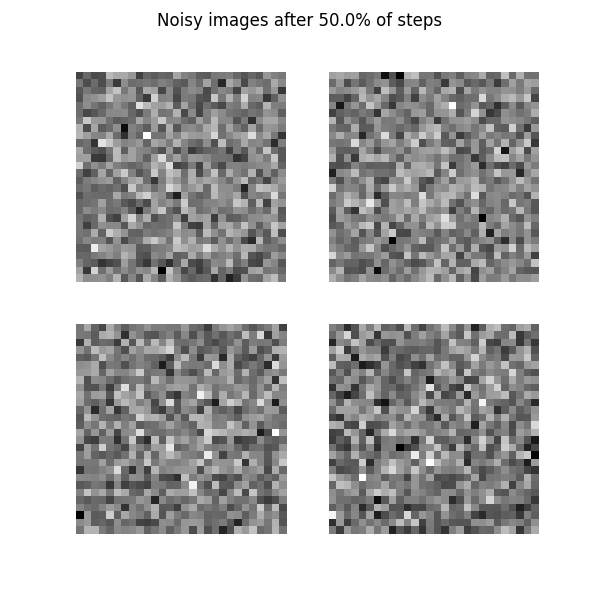

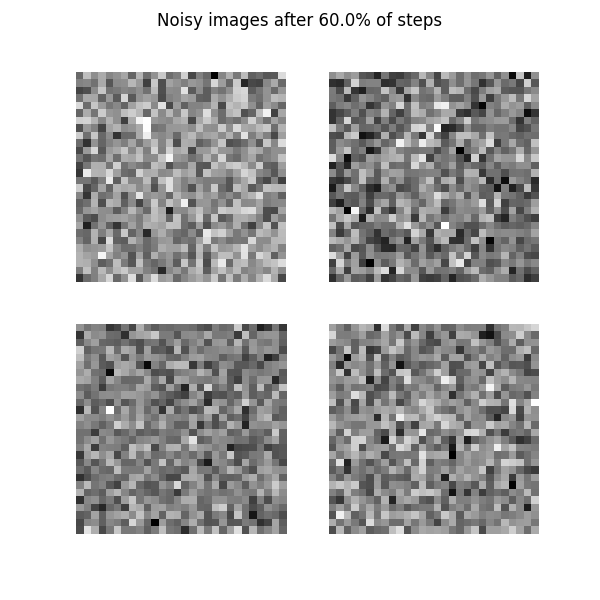

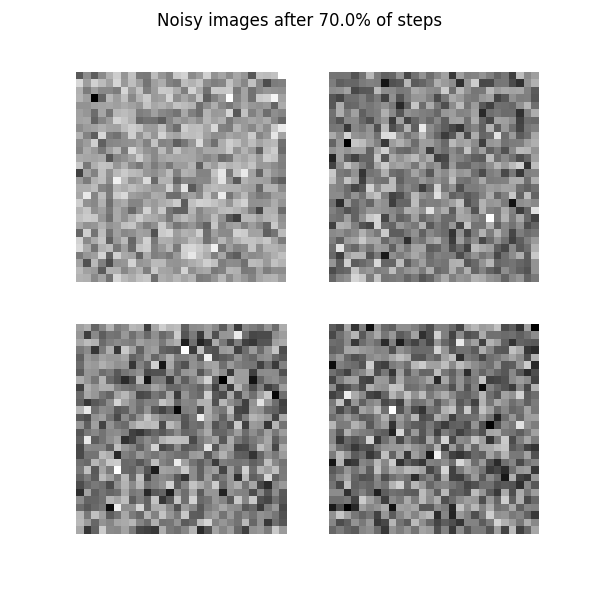

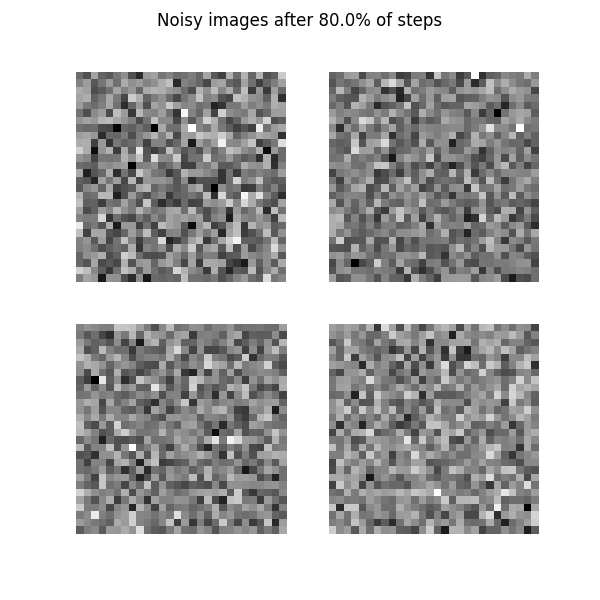

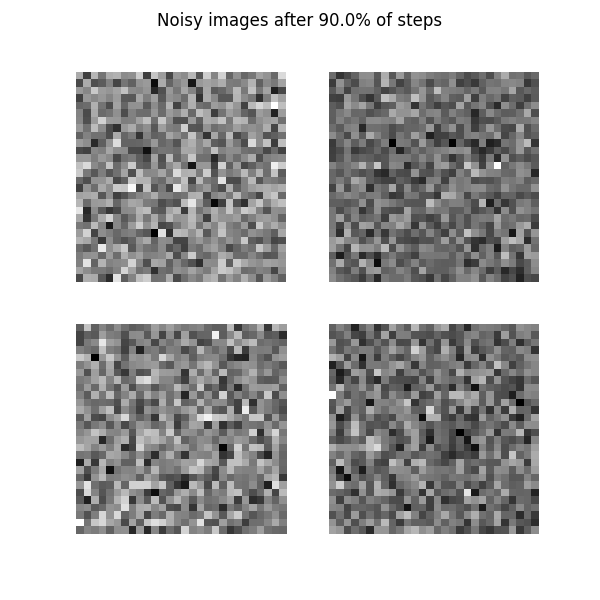

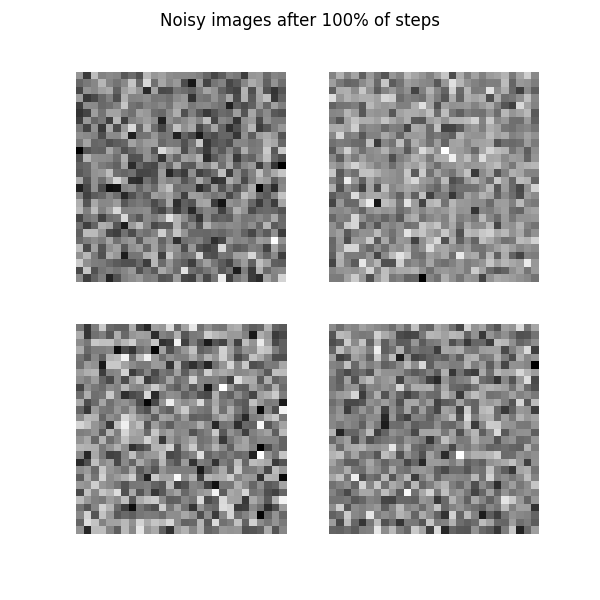

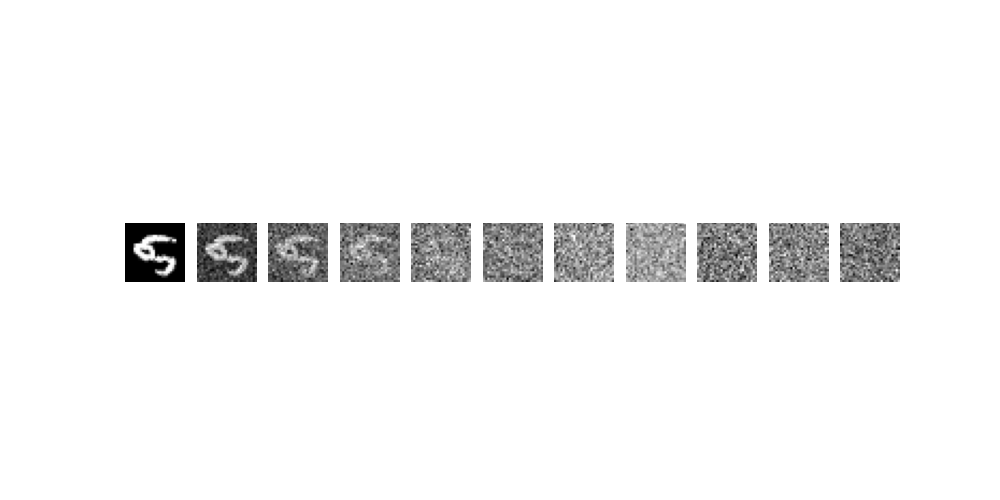

In [104]:
show_forward(ddpm, loader, device)

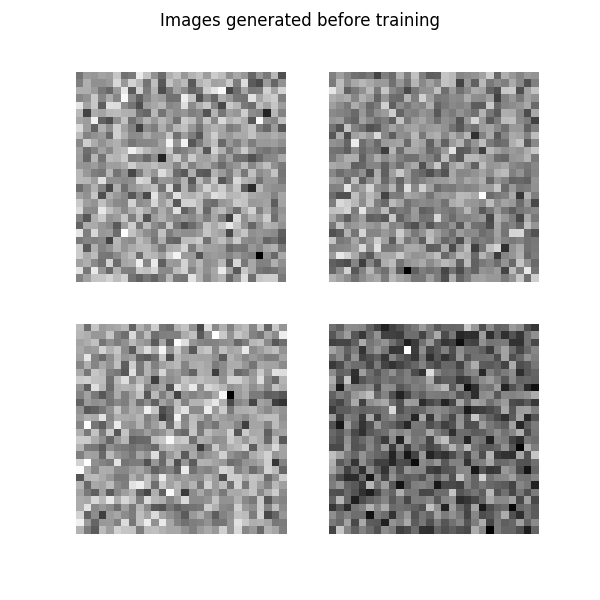

In [105]:
# Optionally, show the denoising (backward) process
generated = generate_new_images(ddpm, gif_name="before_training.gif")
show_images(generated, "Images generated before training")

In [114]:
def training_loop(ddpm, loader, n_epochs, optim, device, display=False, store_path="ddmp_model.pt"):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps

    for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
        epoch_loss = 0
        
        for step, batch in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch + 1}/{n_epochs}", colour="#005500")):
            # Loading data
            x0 = batch[0].to(device)
            n = len(x0)

            # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
            eta = torch.randn_like(x0).to(device)
            t = torch.randint(0, n_steps, size=(n,)).to(device)

            # Computing the noisy image based on x0 and the time-step (forward process)
            noisy_imgs = ddpm(x0, t, eta=eta)

            # Getting model estimation of noise based on the images and the time-step (backward process)
            eta_theta = ddpm.backward(noisy_imgs, t.reshape(n, -1))

            # Optimizing the MSE between the noise plugged and the predicted noise
            loss = mse(eta_theta, eta)
            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_loss += loss.item() * len(x0) / len(loader.dataset)
    
        # Display images generated at this epoch
        if display:
            show_images(generate_new_images(ddpm, device=device), f"Images generated at epoch {epoch + 1}")

        log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"

        # Storing the model
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), store_path)
            log_string += " --> Best model ever (stored)"

        print(log_string)

         

In [115]:
# Training
store_path = "ddpm_fashion.pt" if fashion else "ddpm_mnist.pt"
if not no_train:
    training_loop(ddpm, loader, n_epochs, Adam(ddpm.parameters(), lr=lr), device, display=True, store_path=store_path)

Training progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/15000 [00:00<?, ?it/s]

KeyboardInterrupt: 